{'name': 'MIDRC', 'description': 'MIDRC Excel File', 'data type': 'file', 'filename': 'MIDRC Open A1 and R1 - cumulative by batch.xlsx', 'remove column name text': ['(CUSUM)']}
{'name': 'CDC', 'description': 'CDC Excel File', 'data type': 'file', 'filename': 'CDC_COVIDpos - cumulative by month.xlsx'}
{'name': 'Census', 'description': 'Census Excel File', 'data type': 'file', 'filename': 'Census_all.xlsx', 'date': '2020-01-01'}
{'name': 'MIDRC COVID+', 'description': 'MIDRC COVID+ Excel File', 'data type': 'file', 'filename': 'MIDRC Open A1 and R1 COVIDpos only - cumulative by batch.xlsx', 'remove column name text': ['(CUSUM)']}
Plotting timeline chart...
done with this step


C:\Users\robt_\PycharmProjects\MIDRC_Diversity_Calculator\ipython\jsdview_ipython.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


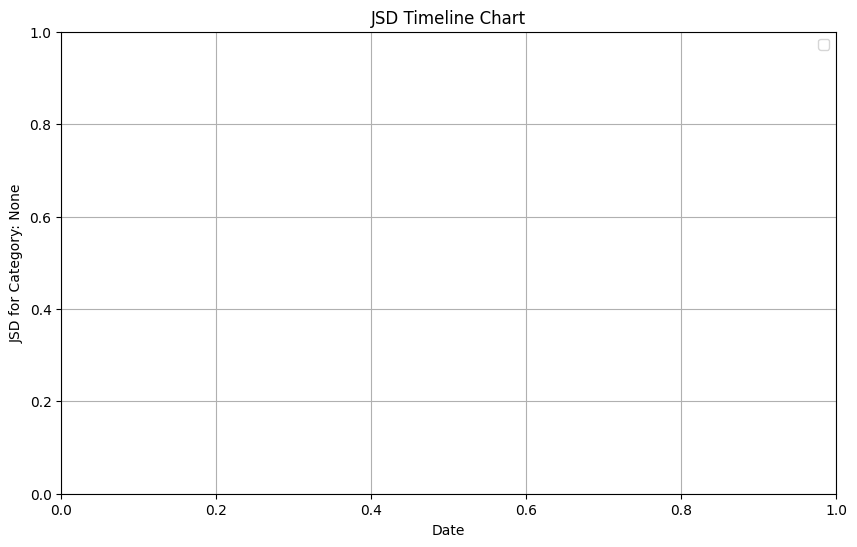

Plotting area charts...
An error occurred during the update of category plots: None


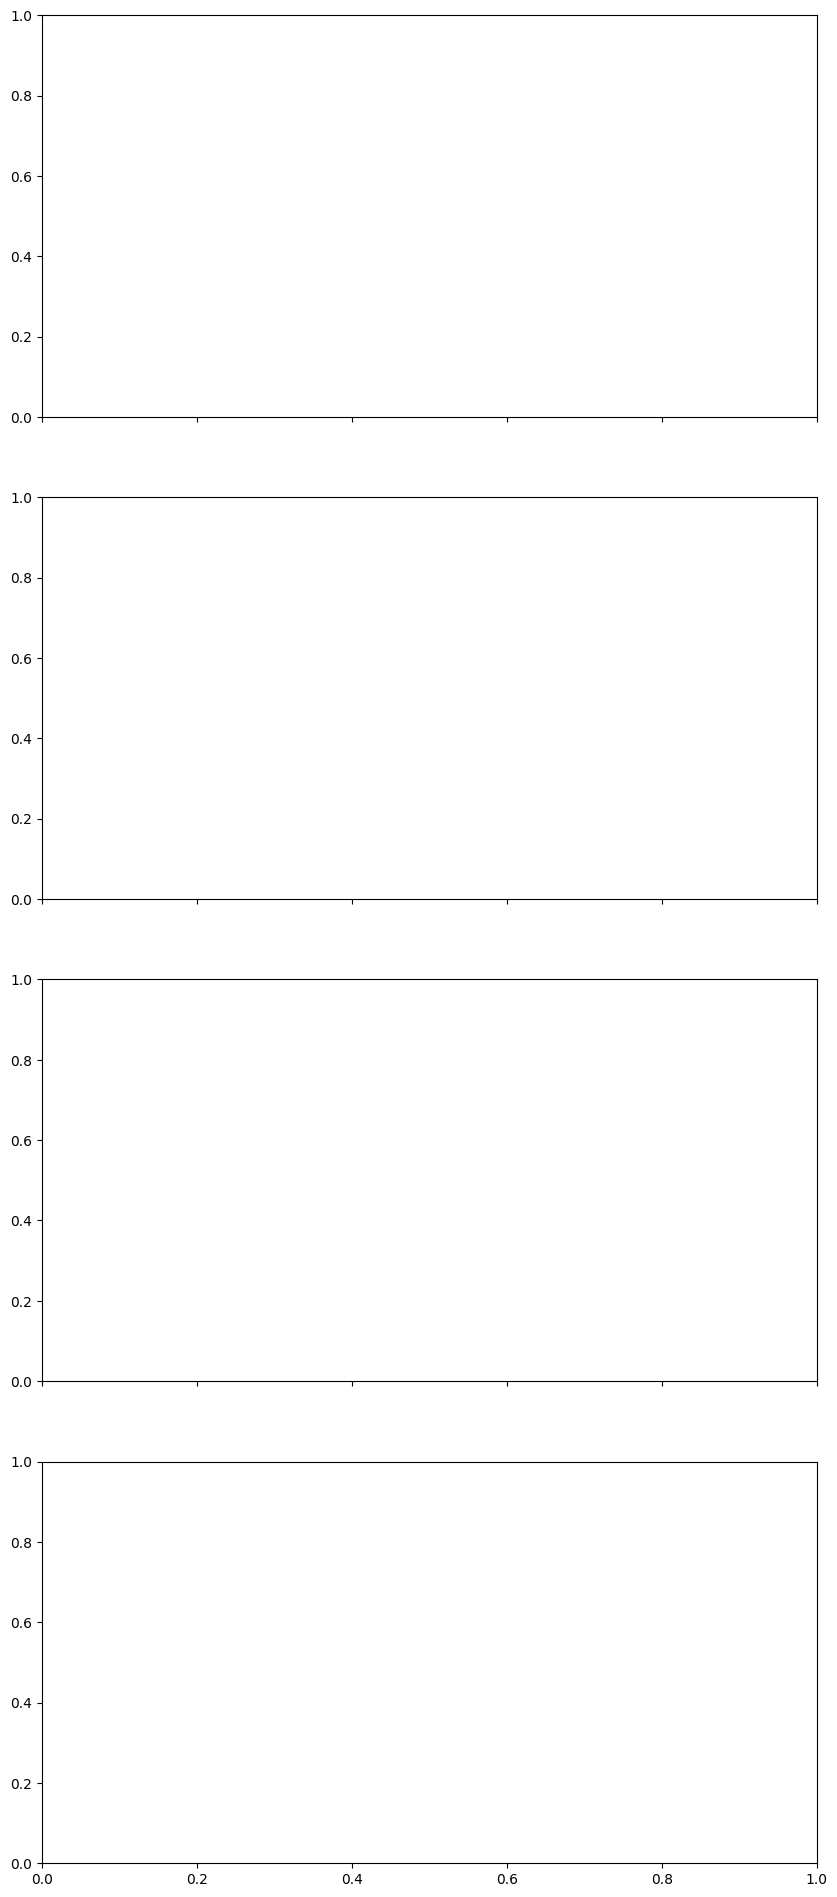

In [3]:
# import jsdview_base
# import jsdcontroller
from jsdconfig import JSDConfig
from jsdcontroller import JSDController
from jsdmodel import JSDTableModel
from ipython.jsdview_ipython import JsdViewIPython

# import importlib
# importlib.reload(jsdview_base)
# importlib.reload(jsdcontroller)

config = JSDConfig()
data_source_list = config.data['data sources']
jsd_table_model = JSDTableModel(None, config.data.get('custom age ranges', None))
# w = JsdWindow(data_source_list)  # Note: We should have the controller populate this once the tablemodel is loaded
jsd_view_base = JsdViewIPython(jsd_table_model)
for data_source in data_source_list:
    print(data_source)
    jsd_view_base.open_excel_file(data_source)
jsd_controller = JSDController(jsd_view_base, jsd_table_model, config)


In [4]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from jsdcontroller import JSDController  # Assuming the backend JSDController is accessible
from PySide6.QtCore import Signal, QObject

'''
# Define a function to plot the timeline chart
def plot_timeline_chart():
    print("Plotting timeline chart...")
    plt.figure(figsize=(10, 6))
    category = data_selection_groupbox.category_combobox.value
    for combobox in data_selection_groupbox.file_comboboxes:
        if combobox.value:
            try:
                print(f"Processing: {combobox.value}")
                file_data = jsd_controller.jsd_model.data_sources[combobox.value].sheets[category].df
                print(file_data.head())  # Debug to see if file_data is accessible
                if file_data.empty:
                    print(f"No data available for {combobox.value} and category {category}. Skipping.")
                    continue  # Skip empty data
                sns.lineplot(data=file_data, x='date', y=file_data.columns[1], label=f'{combobox.value}: {category} ({file_data.columns[1]})')
            except Exception as e:
                print(f"An error occurred while processing {combobox.value}: {e}")
    print('done with this step')
    plt.xlabel('Date')
    plt.ylabel(f'JSD for Category: {category}')
    plt.title('JSD Timeline Chart')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
'''

# Define button to trigger the timeline chart plotting
plot_button = widgets.Button(description='Plot Timeline Chart')
output_timeline = widgets.Output()

def on_plot_button_clicked(b):
    with output_timeline:
        output_timeline.clear_output(wait=True)
        #jsd_view_base.update_jsd_timeline_plot(jsd_table_model)
        jsd_controller.category_changed()

plot_button.on_click(on_plot_button_clicked)

# Connect the category change signal to automatically update the chart
jsd_view_base.data_selection_groupbox.category_changed.connect(jsd_controller.category_changed)
# data_selection_groupbox.category_changed.connect(on_plot_button_clicked)

jsd_view_base.data_selection_groupbox.update_file_comboboxes()

# Display the widgets
display(jsd_view_base.data_selection_groupbox.display(), plot_button, output_timeline)


Button(description='Plot Timeline Chart', style=ButtonStyle())

Output()

In [ ]:
jsd_view_base.update_area_chart()